**Gerekli kütüphanelerin eklenmesi**

In [9]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


Öncelikle veri setimizi Pandas kütüphanesi kullanarak *DataFrame*'e dönüştürüyouz. Böylelikle veri setimizde bulunan png dosyaları ile daha kolay çalışabiliriz.

In [10]:
base_path = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

data = []
for species_folder in os.listdir(base_path):
    species_path = os.path.join(base_path, species_folder)
    if os.path.isdir(species_path):
        for subfolder in os.listdir(species_path):
            subfolder_path = os.path.join(species_path, subfolder)
            if os.path.isdir(subfolder_path) and not subfolder.endswith('GT'):
                for file in os.listdir(subfolder_path):
                    file_path = os.path.join(subfolder_path, file)
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                        try:
                            img = Image.open(file_path)
                            img = img.resize((128, 128))  # Görüntü boyutunu küçültme
                            img_array = np.array(img)
                            data.append({
                                'image': img_array,
                                'label': species_folder,
                                'file_name': file
                            })
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")

df = pd.DataFrame(data)
print(f"Total images loaded: {len(df)}")


Total images loaded: 9000


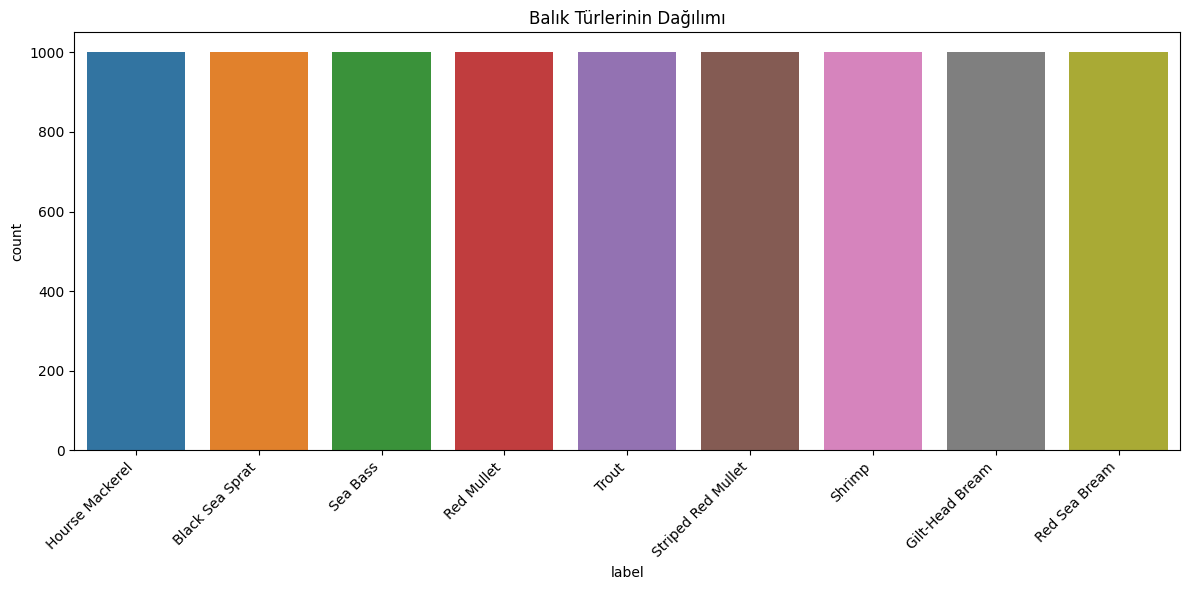

Görüntü boyutları istatistikleri:
       image_height  image_width  image_channels
count        9000.0       9000.0          9000.0
mean          128.0        128.0             3.0
std             0.0          0.0             0.0
min           128.0        128.0             3.0
25%           128.0        128.0             3.0
50%           128.0        128.0             3.0
75%           128.0        128.0             3.0
max           128.0        128.0             3.0


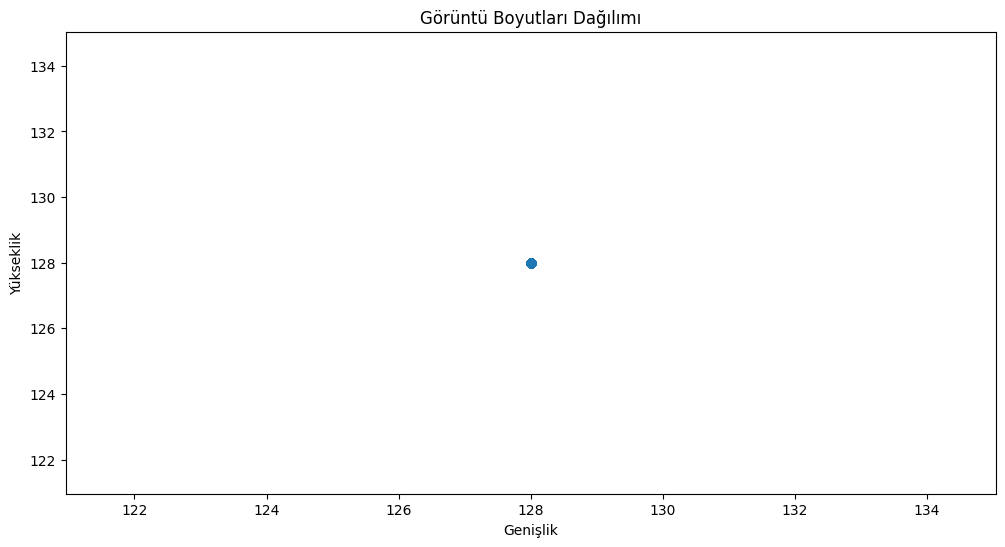

In [11]:
# Balık türlerinin dağılımı
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label')
plt.title('Balık Türlerinin Dağılımı')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Görüntü boyutları istatistikleri
df['image_shape'] = df['image'].apply(lambda x: x.shape)
df['image_height'] = df['image_shape'].apply(lambda x: x[0])
df['image_width'] = df['image_shape'].apply(lambda x: x[1])
df['image_channels'] = df['image_shape'].apply(lambda x: x[2] if len(x) > 2 else 1)

print("Görüntü boyutları istatistikleri:")
print(df[['image_height', 'image_width', 'image_channels']].describe())

# Görüntü boyutları dağılımı
plt.figure(figsize=(12, 6))
plt.scatter(df['image_width'], df['image_height'], alpha=0.5)
plt.xlabel('Genişlik')
plt.ylabel('Yükseklik')
plt.title('Görüntü Boyutları Dağılımı')
plt.show()


In [12]:
# Etiketleri sayısal formata dönüştürme
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Veriyi ve etiketleri ayırma
X = np.stack(df['image'].values)  # Görüntüler
y = to_categorical(df['label_encoded'])  # Etiketler

# Eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi normalize etme
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [13]:
model = Sequential()

# İlk katman: Giriş ve yoğun katman
model.add(Flatten(input_shape=(128, 128, 3)))  # Görüntüyü düzleştiriyoruz
model.add(Dense(256, activation='relu'))  # 256 nöronlu tam bağlantılı katman
model.add(Dropout(0.5))  # Aşırı öğrenmeyi önlemek için %50 dropout

# İkinci yoğun katman
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # %30 dropout

# Çıkış katmanı: Softmax ile çok sınıflı sınıflandırma
model.add(Dense(len(df['label'].unique()), activation='softmax'))

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,617,225 (48.13 MB)

 Trainable params: 12,617,225 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.1208 - loss: 5.2471 - val_accuracy: 0.0994 - val_loss: 2.1981
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.1147 - loss: 2.1974 - val_accuracy: 0.0994 - val_loss: 2.1979
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.1062 - loss: 2.1975 - val_accuracy: 0.0994 - val_loss: 2.1978
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.1203 - loss: 2.1969 - val_accuracy: 0.0994 - val_loss: 2.1979
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.1124 - loss: 2.1976 - val_accuracy: 0.0994 - val_loss: 2.1979
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.1115 - loss: 2.1975 - val_accuracy: 0.0994 - val_loss: 2.1979
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.1163 - loss: 2.1973 - val_accuracy: 0.0994 - val_loss: 2.1980
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.1157 - loss: 2

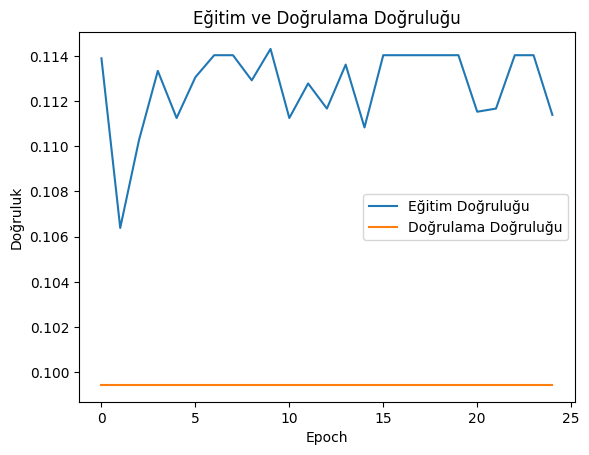

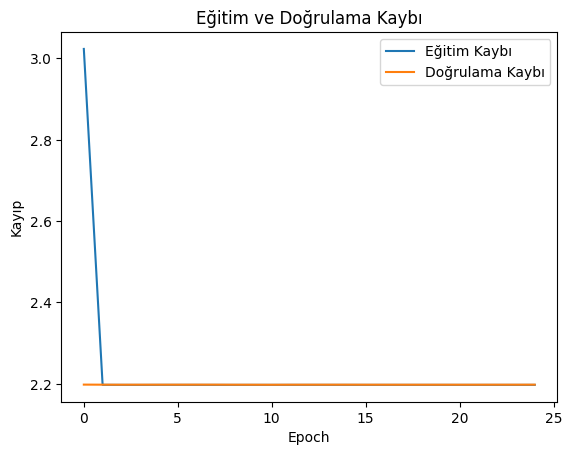

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

# Eğitim ve doğrulama kayıpları ve doğrulukları
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()
plt.show()


**Modelin Değerlendirilmesi**

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


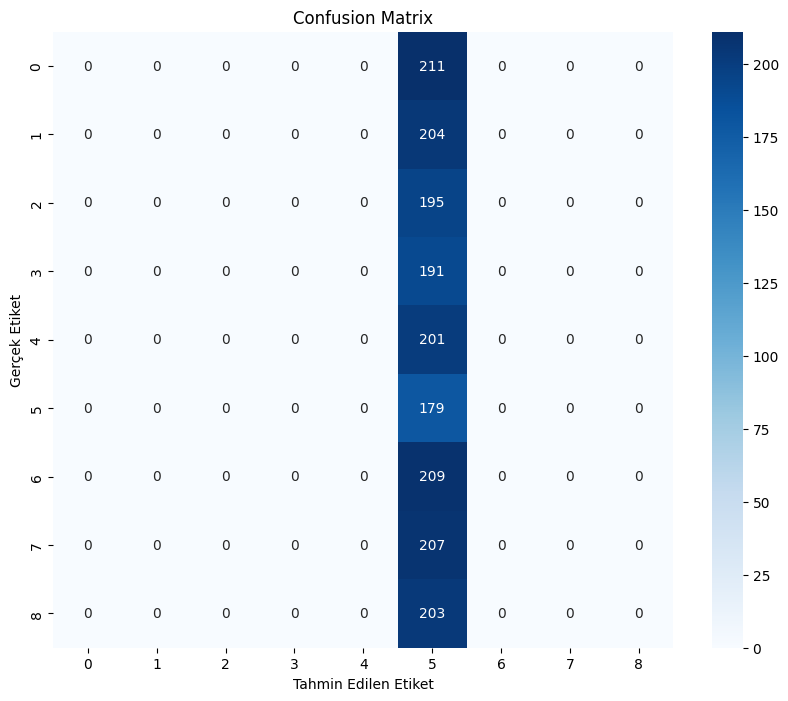

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       211
           1       0.00      0.00      0.00       204
           2       0.00      0.00      0.00       195
           3       0.00      0.00      0.00       191
           4       0.00      0.00      0.00       201
           5       0.10      1.00      0.18       179
           6       0.00      0.00      0.00       209
           7       0.00      0.00      0.00       207
           8       0.00      0.00      0.00       203

    accuracy                           0.10      1800
   macro avg       0.01      0.11      0.02      1800
weighted avg       0.01      0.10      0.02      1800



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


# Tahminleri yapma
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix çizme
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


**Hiperparametre Optimizasyonu**

In [16]:
def create_model(layer_1_neurons=512, layer_2_neurons=256, dropout_1=0.5, dropout_2=0.3, learning_rate=0.001):
    model = Sequential()
    
    # İlk katman
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(layer_1_neurons, activation='relu'))
    model.add(Dropout(dropout_1))
    
    # İkinci katman
    model.add(Dense(layer_2_neurons, activation='relu'))
    model.add(Dropout(dropout_2))
    
    # Çıkış katmanı
    model.add(Dense(len(df['label'].unique()), activation='softmax'))
    
    # Model derleme
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Örnek deneme (Hiperparametreleri değiştirerek)
model = create_model(layer_1_neurons=256, layer_2_neurons=128, dropout_1=0.4, dropout_2=0.3, learning_rate=0.0005)

# Modeli eğitme
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.1236 - loss: 3.4353 - val_accuracy: 0.0994 - val_loss: 2.1973
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.1110 - loss: 2.1973 - val_accuracy: 0.0994 - val_loss: 2.1974
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.1140 - loss: 2.1973 - val_accuracy: 0.0994 - val_loss: 2.1975
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.1084 - loss: 2.1973 - val_accuracy: 0.0994 - val_loss: 2.1976
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.1131 - loss: 2.1973 - val_accuracy: 0.0994 - val_loss: 2.1977
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.1150 - loss: 2.1971 - val_accuracy: 0.0994 - val_loss: 2.1977
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.1149 - loss: 2.1971 - val_accuracy: 0.0994 - val_loss: 2.1977
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.1192 - loss: 2